In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.sparse import csr_matrix

In [2]:
COLUMN_NAMES = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "gain",
]

In [3]:
def clean_dataset(df_local: pd.DataFrame) -> pd.DataFrame:
    df_local = strip_strings(df_local)
    initial_entries = len(df_local)
    df_local.drop_duplicates(inplace=True)
    deduplicated_entries = len(df_local)
    duplicated_entries = initial_entries - deduplicated_entries
    print("Deleted duplicated rows: {}, {}%".format(
        duplicated_entries, round(100 * duplicated_entries / initial_entries, 0)
            )
        )
    df_local.dropna(inplace=True)
    dedup_not_na_entries = len(df_local)
    notna_entries = deduplicated_entries - dedup_not_na_entries
    print("Deleted rows with empty values: {}, {}%".format(
        notna_entries, round(100 * notna_entries / initial_entries, )
            )
        )
    df_cleaned = delete_rows_with_question_mark(df_local)
    cleaned_entries = len(df_cleaned)
    question_mark_entries = dedup_not_na_entries - cleaned_entries
    print("Number of entries in a dataset after cleaning: {}, {}% from initial dataset were dismissed".format(
        cleaned_entries, round(100 *  (initial_entries - cleaned_entries)/ initial_entries, 0)
            )
        )
    df_cleaned.columns = COLUMN_NAMES
    race_list = list(df_cleaned["race"])
    df_cleaned.insert(loc=len(df_cleaned.columns), column='is_white', value=get_race_category_list(race_list))
    
    return df_cleaned
    
def delete_rows_with_question_mark(df_local: pd.DataFrame) -> pd.DataFrame:
    df_local.copy(deep=True)
    # Create a boolean mask for rows containing "?"
    mask = df_local.apply(lambda row: any(["?" in str(cell) for cell in row]), axis=1)
    
    # Invert the mask to keep rows not containing "?"
    inverted_mask = ~mask
    
    # Filter the DataFrame to keep only rows not containing "?"
    df_local = df_local[inverted_mask]
    
    return df_local

def get_race_category_list(race_list: list) -> list:
    # Define a list of values that are considered as "White"
    white_values = ['White'] 
    
    race_category = []
    for race in race_list:
        if race.strip() in white_values:
            race_category.append('white')
        else:
            race_category.append('non-white')
    return race_category

def strip_strings(df_local: pd.DataFrame) -> pd.DataFrame:
    # Iterate over all columns
    for col in df_local.columns:
        # Check if the column contains string values
        if df_local[col].dtype == 'object':
            # Strip string values
            df_local[col] = df_local[col].str.strip()
    return df_local

## 1. Cleaning the dataset

In [4]:
df_raw = pd.read_csv("census+income/adult.data")
df_raw_processed = clean_dataset(df_raw)

Deleted duplicated rows: 24, 0.0%
Deleted rows with empty values: 0, 0%
Number of entries in a dataset after cleaning: 30138, 7.0% from initial dataset were dismissed


In [5]:
# on order to make processing of training and testing datasets consistent, 
# I delete one row containing native country not appearing in test dataset
value_to_drop = 'Holand-Netherlands'
df = df_raw_processed[df_raw_processed["native_country"] != value_to_drop]

## 2. Let's focus on sensetive attributes: race and gender

In [6]:

def plot_attribute_distribution(df, column_name, figsize=(5, 3), annotaion_rotation=0):
    # Calculate the counts of each category in the specified column
    attribute_counts = df[column_name].value_counts()
    
    # Define colors based on column values
    colors = []
    if column_name == 'gender':
        colors = ['royalblue', 'salmon']
    elif column_name == 'is_white':
        colors = ['lightgrey', 'brown']
    else:
        colors = "royalblue"
    # Calculate the percentage of occurrence for each category
    attribute_percentage = (attribute_counts / attribute_counts.sum()) * 100
    
    # Plot the histogram
    plt.figure(figsize=figsize)  # Adjust the figure size as needed
    bars = plt.bar(attribute_counts.index, attribute_counts.values, color=colors)
    plt.xlabel(column_name.capitalize(), fontsize=14)  # Capitalize the column name for better readability
    plt.ylabel('Count', fontsize=14)
    plt.title(f'{column_name} distribution', fontsize=16)
    plt.xticks(rotation=70, fontsize=12)  # Rotate x-axis labels for better readability if needed
    plt.yticks(fontsize=12)

    # Set the maximum y-axis limit to 30,000
    plt.ylim(top=29000)
    
    # Remove box around the graph
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Annotate bars with percentages with larger font size
    for bar, count, percentage in zip(bars, attribute_counts.values, attribute_percentage.values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=12)
    
    plt.show()

def plot_grouped_attribute_distribution(df, group_column, attribute_column, figsize=(5,4), annotaion_rotation=0):
    # Define colors based on column values
    colors = []
    if 'gender' in [group_column, attribute_column]:
        colors = ['royalblue', 'salmon']
    elif 'is_white' in [group_column, attribute_column]:
        colors = ['lightgrey', 'brown']
    else:
        colors = "royalblue"
    # Calculate the percentage of
    # Group the DataFrame by the gender column and attribute column, and calculate the counts for each group
    attribute_counts = df.groupby([group_column, attribute_column]).size().unstack(fill_value=0)
    
    # Calculate the total counts for each category in the gender column
    total_counts = attribute_counts.sum(axis=1)
    
    # Calculate the percentages for each category in the gender column and attribute column
    attribute_percentages = attribute_counts.div(total_counts, axis=0) * 100
    attribute_percentages_trans = attribute_percentages.T
    attribute_percentages_trans = attribute_percentages_trans [attribute_percentages_trans.columns[::-1]]

    N_groups = len(attribute_percentages_trans.index)
    x = np.arange(N_groups)  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained',figsize=figsize)
    
    for attribute, measurement in attribute_percentages_trans.items():
        offset = width * multiplier
        bars = ax.bar(x + offset, measurement, width, label=attribute, color=colors[multiplier])
        ax.bar_label(bars, fmt=lambda x: f'{x:.1f}%', padding=3, fontsize=14, rotation=annotaion_rotation)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title('{} distribution by {}'.format(attribute_column, group_column), fontsize=16)
    ax.set_xticks(x + width/N_groups, attribute_percentages_trans.index, rotation=70, fontsize=12)
    ax.legend(loc='upper right')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.show()

def create_cat_n_num_col_list(df_local: pd.DataFrame) -> (list, list):
    numerical_columns = []
    categorical_columns = []
    for col in df_local.columns:
        if df_local[col].dtype=='object':
            categorical_columns.append(col)
        elif df_local[col].dtype=='int64':
            numerical_columns.append(col)
    return (numerical_columns, categorical_columns)

### 2.1 Dataset is skewed: not equal amounts of sensetive groups

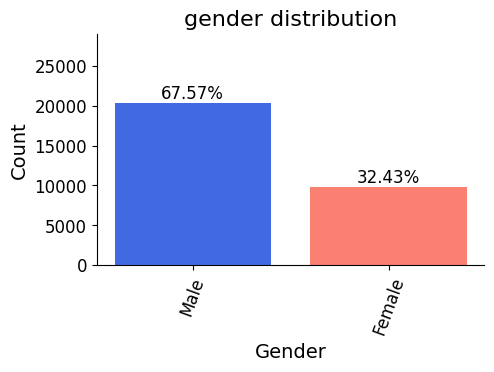

In [7]:
plot_attribute_distribution(df, "gender")

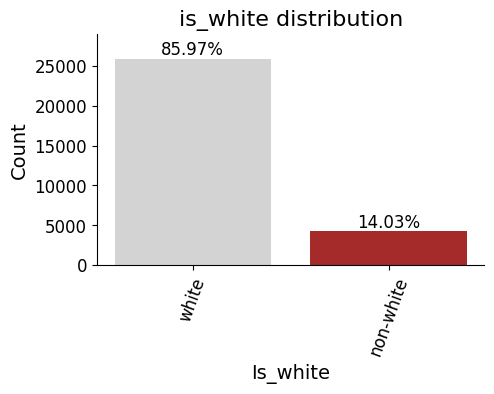

In [8]:
plot_attribute_distribution(df, "is_white")

### 2.2 Let's make a bit deeper analysis of the dataset

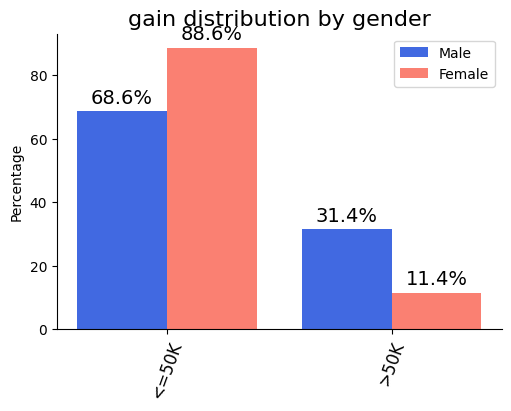

In [9]:
plot_grouped_attribute_distribution(df, "gender", "gain")

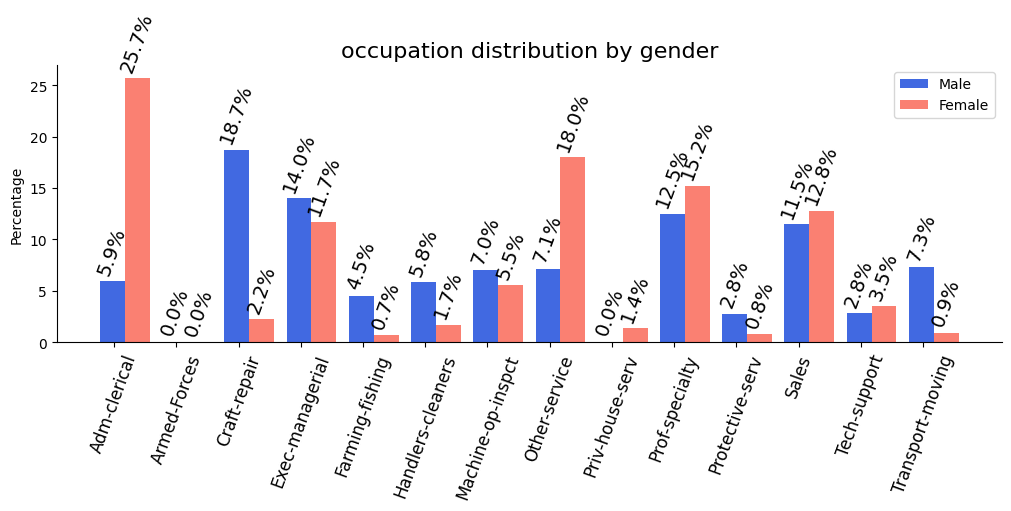

In [10]:
plot_grouped_attribute_distribution(df, "gender", "occupation", figsize=(10,5), annotaion_rotation=70)

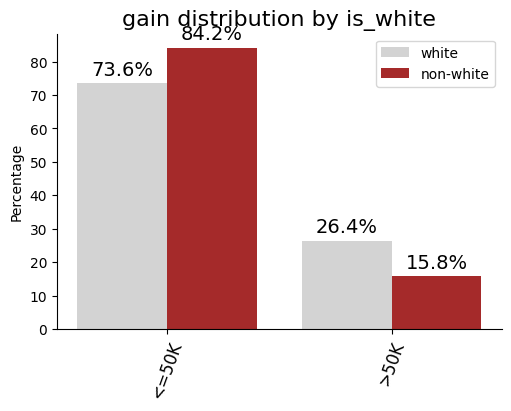

In [11]:
plot_grouped_attribute_distribution(df, "is_white", "gain")

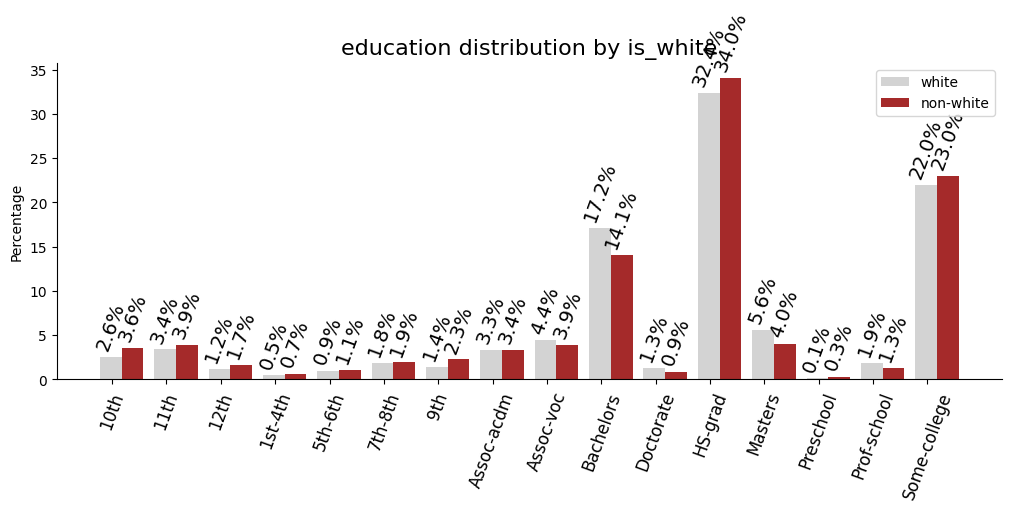

In [12]:
plot_grouped_attribute_distribution(df, "is_white", "education", figsize=(10,5), annotaion_rotation=70)

## 3. Make a prediction

In [87]:
# Step 2: Get X  - vector of features
X = df.drop(columns=["gain", "education", "fnlwgt", "race"])  #column "education" is categorical renaming of "education-num"

In [136]:
def get_X_Y_from_df(df_local: pd.DataFrame) -> (csr_matrix, np.ndarray):
    # Get X  - vector of features
    X = df_local.drop(columns=["gain", "education", "fnlwgt", "race"])  #column "education" is categorical renaming of "education-num"
    #get lists of categorical and numerical features for X
    numerical_columns, categorical_columns = create_cat_n_num_col_list(X)
    
    # Perform one-hot-encoding on categorical variables
    df_onehot = pd.get_dummies(X[categorical_columns])
    y_raw = pd.get_dummies(df_local["gain"])
    if ">50K." in y_raw.columns:
        y_raw = y_raw.rename(columns={">50K.": ">50K", "<=50K.": "<=50K"})
    y = y_raw.loc[:, ">50K"]  
    
    # Fit and transform the numerical columns using RobustScaler
    scaler = RobustScaler()
    scaled_numerical = scaler.fit_transform(df_local[numerical_columns])
    scaled_df = pd.DataFrame(scaled_numerical, columns=numerical_columns, index=X.index)
    
    df_ready_for_ML = pd.concat([scaled_df, df_onehot], axis=1)

    return (df_ready_for_ML, y)

In [137]:
X_processed, y = get_X_Y_from_df(df)

model = MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', max_iter=1000, random_state=2)

# Perform 3-fold cross-validation
cv_scores = cross_val_score(model, X_processed, np.ravel(y), cv=3)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.84640653 0.80977503 0.8566451 ]
Mean CV accuracy: 0.8376088872883756


In [138]:
model.fit(X_processed, np.ravel(y))

MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=2)

In [139]:
df_test_raw = pd.read_csv("census+income/adult.test", skiprows=[0], header=None)
df_test = clean_dataset(df_test_raw)

Deleted duplicated rows: 5, 0.0%
Deleted rows with empty values: 0, 0%
Number of entries in a dataset after cleaning: 15055, 8.0% from initial dataset were dismissed


In [142]:
X_test_processed, y_test = get_X_Y_from_df(df_test)

In [161]:
y_test_predictions

array([False, False,  True, ...,  True,  True,  True])

AttributeError: 'Series' object has no attribute 'type'

In [ ]:
y_test

In [143]:
y_test_predictions = model.predict(X_test_processed)

In [199]:
groundtruth_df = pd.concat([X_test_processed, y_test], axis=1)
predicted_df = pd.concat([X_test_processed, pd.Series(y_test_predictions, index=y_test.index, name=y_test.name)], axis=1)

In [120]:
accuracy = accuracy_score(y_test, y_test_predictions)
accuracy

0.8365991364995018

In [200]:
conf_matrix = confusion_matrix(y_test, y_test_predictions)

In [215]:
def get_TPR_FPR_per_group(df_local_pred: pd.DataFrame, df_local_test: pd.DataFrame, feature_of_interest: str) -> (float, float, float):
    y_truth = df_local_test[df_local_test[feature_of_interest] ==True]['>50K']   
    y_pred = df_local_pred[df_local_pred[feature_of_interest] ==True]['>50K']
    
    TP = confusion_matrix(y_truth, y_pred)[1,1]
    FP = confusion_matrix(y_truth, y_pred)[0,1]
    
    PR = sum(y_pred)/len(y_pred)
    TPR = TP/(TP+FP)
    FPR = FP/(TP+FP)

    
    return PR, TPR, FPR

In [217]:
PR_female, TPR_female, FPR_female = get_TPR_FPR_per_group(predicted_df, groundtruth_df, "gender_Female")
print(PR_female, TPR_female, FPR_female)
PR_male, TPR_male, FPR_male = get_TPR_FPR_per_group(predicted_df, groundtruth_df, "gender_Male")
print(PR_male, TPR_male, FPR_male)

0.11828175895765472 0.612736660929432 0.387263339070568
0.32347431726313713 0.6690033526363913 0.3309966473636087


In [197]:
# Assuming 'protected_feature' is the name of your protected feature,
# 'label' is the name of your label, and other columns are features
protected_attribute = 'gender_Female'
label_name = '>50K'



# Create a BinaryLabelDataset object
groundtruth_dataset = BinaryLabelDataset(favorable_label=1,
                             unfavorable_label=0,
                             df=groundtruth_df,
                             label_names=[label_name],
                             protected_attribute_names=[protected_attribute])

predicted_dataset = BinaryLabelDataset(favorable_label=1,
                             unfavorable_label=0,
                             df=predicted_df,
                             label_names=[label_name],
                             protected_attribute_names=[protected_attribute])

metric = ClassificationMetric(groundtruth_dataset,  # True labels
                              predicted_dataset,  # Predicted labels
                              privileged_groups=[{protected_attribute: False}],
                              unprivileged_groups=[{protected_attribute: True}])  

demographic_parity = metric.disparate_impact()
equal_opportunity = metric.equal_opportunity_difference()
equalized_odds = metric.average_odds_difference()
true_positive_rate = metric.consistency()

# Display the fairness metrics
print("Demographic parity:", demographic_parity)
print("Equal opportunity:", equal_opportunity)
print("Equalized odds:", equalized_odds)
print("True Positive Rate", true_positive_rate)

Demographic parity: 0.36566043313242663
Equal opportunity: -0.05923910590974446
Equalized odds: -0.08135860494765557
True Positive Rate [0.85343075]
